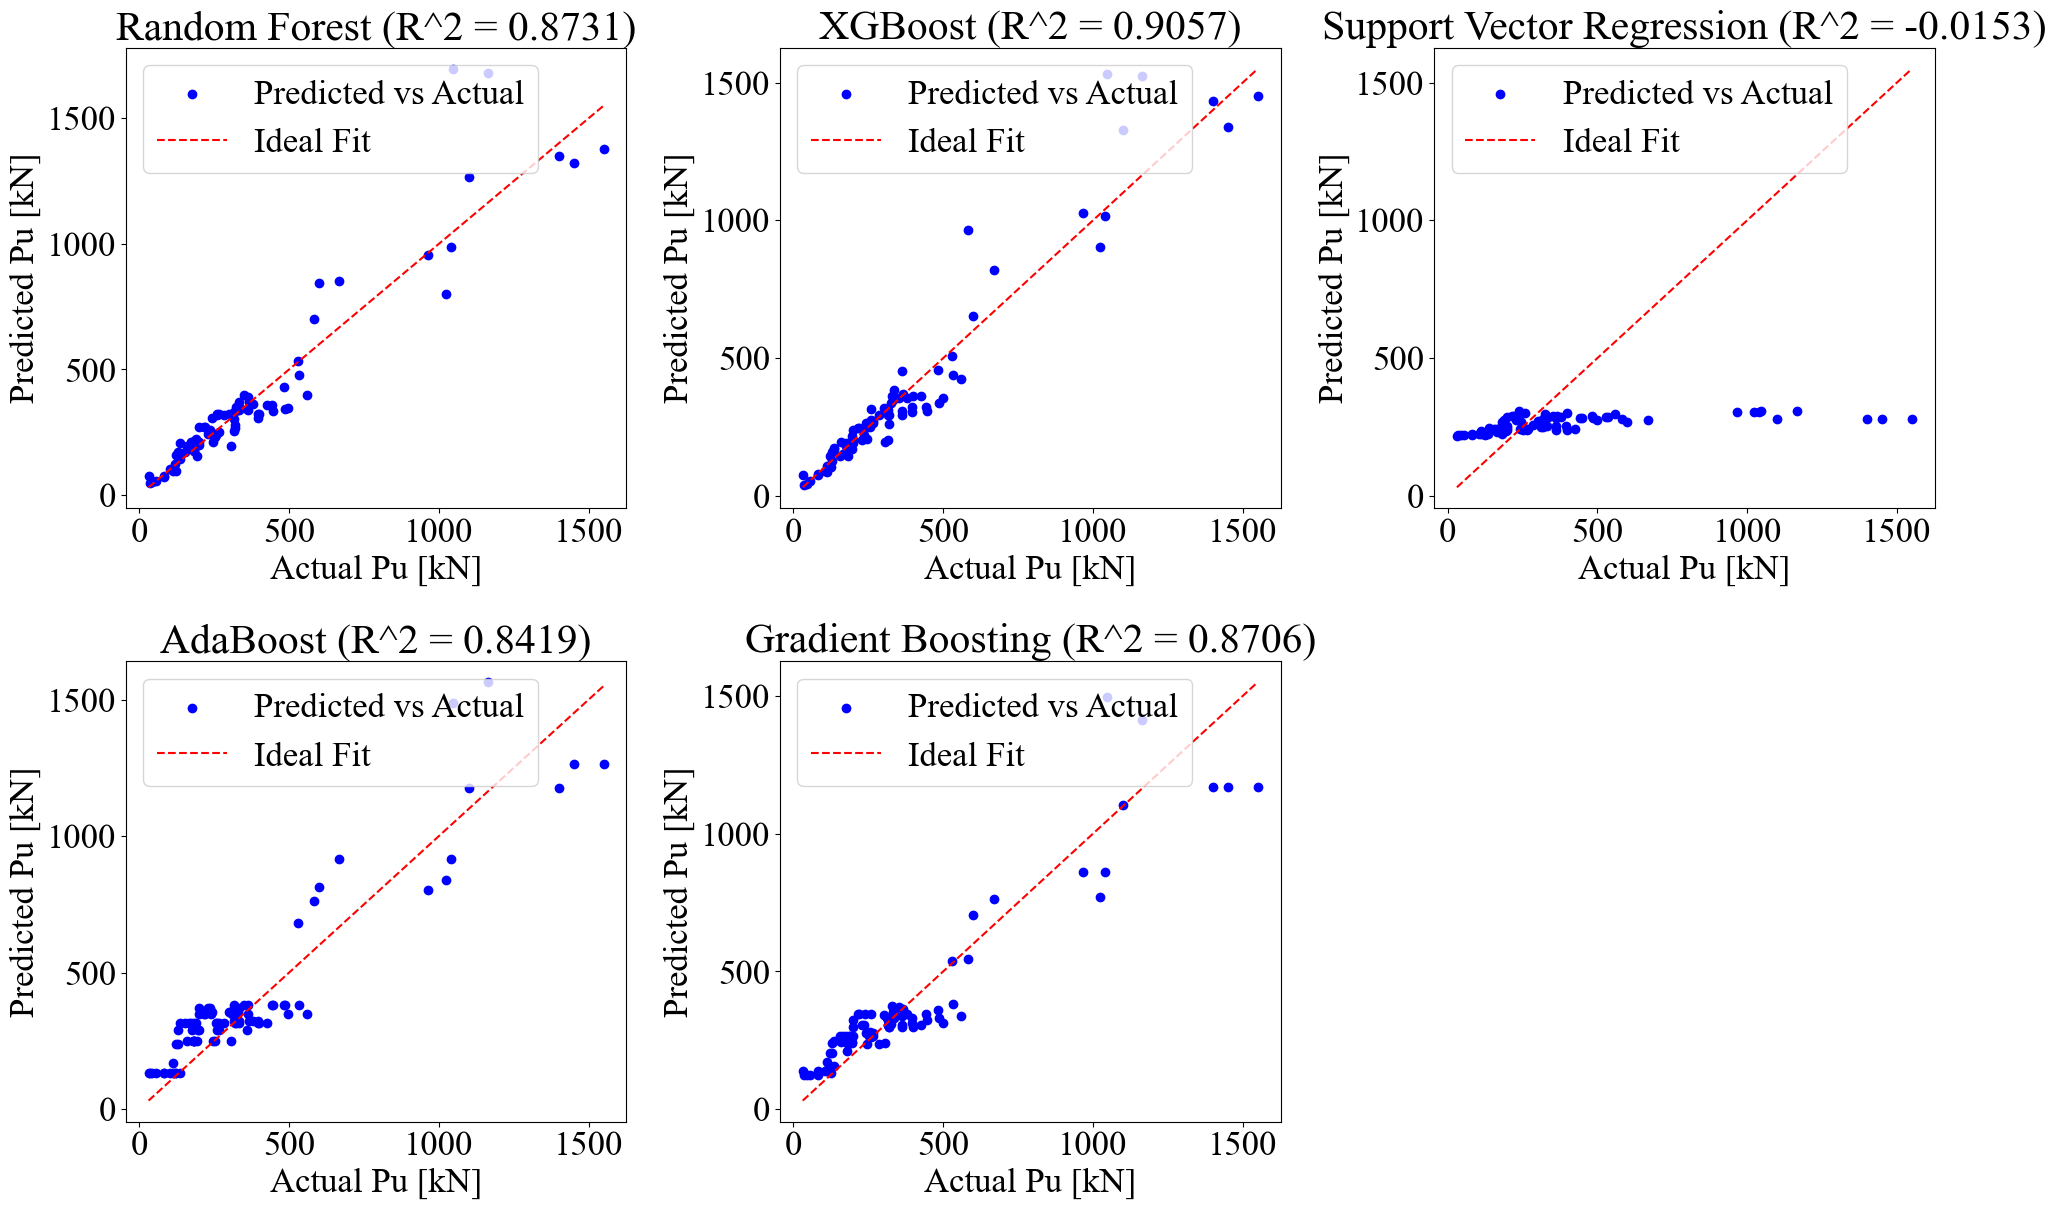

In [17]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Excel 파일에서 데이터 불러오기
file_path = '../데이터 베이스/final_data.xlsx'
data = pd.read_excel(file_path, sheet_name='NEES_Database__ACI_445_Punching')

# 결측값이 있는 행을 삭제합니다.
data.dropna(inplace=True)

# 데이터를 준비합니다.
X = data[['a_davg', 'b/d', 'fy/fc', 'f1c', 'b1', 'davg', 'ravg', 'Shape(s=1 r=2 c=3)']]
y = data['Pu']

# 데이터를 훈련 세트와 테스트 세트로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 초기화
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, max_depth=5),
    'Support Vector Regression': SVR(),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=20, random_state=42)
}

# 전역적으로 글씨 크기와 폰트 설정 (Times New Roman)
plt.rcParams.update({'font.size': 25, 'font.family': 'Times New Roman'})  # Times New Roman으로 폰트 설정

# 각 모델 훈련 및 예측
plt.figure(figsize=(20, 18))  # 크기를 조금 더 키워서 그래프들이 겹치지 않게 함
for i, (model_name, model) in enumerate(models.items(), 1):
    # 모델 훈련
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # R^2 계산
    r2 = r2_score(y_test, y_pred)
    
    # 서브플롯 생성
    plt.subplot(3, 3, i)
    plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
    plt.xlabel('Actual Pu [kN]')
    plt.ylabel('Predicted Pu [kN]')
    plt.title(f'{model_name} (R^2 = {r2:.4f})')
    plt.legend()

# 그래프 PDF로 저장
plt.tight_layout()
plt.savefig('model_comparison_graph.pdf', format='pdf')

# 그래프 출력
plt.show()


Training Models: 100%|██████████| 247/247 [00:38<00:00,  6.47combination/s]


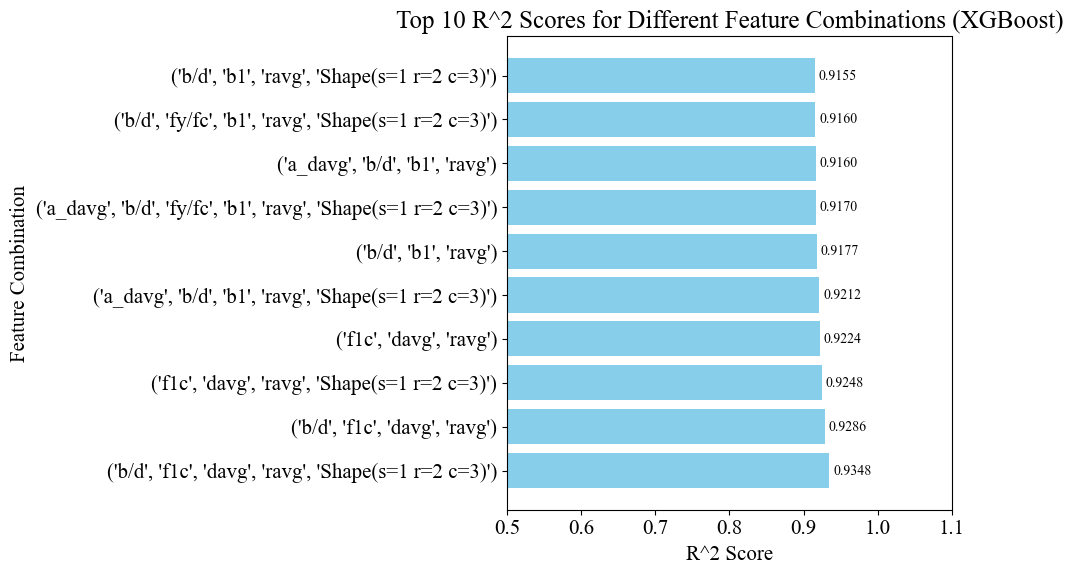

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import xgboost as xgb
import itertools
from tqdm import tqdm  # tqdm 임포트

# Excel 파일에서 데이터 불러오기
file_path = '../데이터 베이스/final_data.xlsx'
data = pd.read_excel(file_path, sheet_name='NEES_Database__ACI_445_Punching')

# 결측값이 있는 행을 삭제합니다.
data.dropna(inplace=True)

# 데이터를 준비합니다.
X = data[['a_davg', 'b/d', 'fy/fc', 'f1c', 'b1', 'davg', 'ravg', 'Shape(s=1 r=2 c=3)']]
y = data['Pu']

# 데이터를 훈련 세트와 테스트 세트로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모든 가능한 입력 변수 조합을 생성합니다.
features = X.columns
combinations = []
for r in range(2, len(features) + 1):  # 2개 조합부터 시작해서 전체 조합까지
    combinations.extend(itertools.combinations(features, r))

# 각 조합에 대해 XGBoost 모델 훈련 및 평가
r2_scores = {}
for combo in tqdm(combinations, desc="Training Models", unit="combination"):
    # 해당 조합으로 X_train, X_test를 선택합니다.
    X_train_combo = X_train[list(combo)]
    X_test_combo = X_test[list(combo)]
    
    # XGBoost 모델을 초기화하고 훈련시킵니다.
    model = xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train_combo, y_train)
    
    # 예측 수행
    y_pred = model.predict(X_test_combo)
    
    # R^2 계산
    r2 = r2_score(y_test, y_pred)
    r2_scores[str(combo)] = r2

# R^2 값들을 내림차순으로 정렬하여 상위 10개 선택
sorted_r2_scores = sorted(r2_scores.items(), key=lambda x: x[1], reverse=True)[:10]

# 상위 10개 조합과 R^2 값 추출
top_combinations = [item[0] for item in sorted_r2_scores]
top_r2_values = [item[1] for item in sorted_r2_scores]

# 그래프 출력
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 15, 'font.family': 'Times New Roman'})  # Times New Roman으로 폰트 설정
bars = plt.barh(top_combinations, top_r2_values, color='skyblue')

# 그래프에 R^2 값 표시
for bar, r2 in zip(bars, top_r2_values):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f'{r2:.4f}', 
             va='center', ha='left', fontsize=10, color='black')

# x축 범위 설정
plt.xlim(0.5, 1.1)

plt.xlabel('R^2 Score')
plt.ylabel('Feature Combination')
plt.title('Top 10 R^2 Scores for Different Feature Combinations (XGBoost)')
plt.tight_layout()

# 그래프 PDF로 저장
plt.savefig('top_r2_scores_graph.pdf', format='pdf')

# 그래프 표시
plt.show()

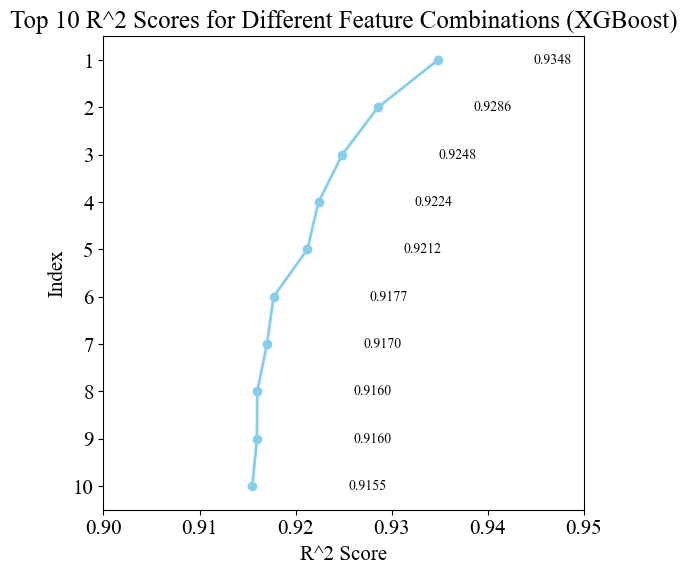

In [ ]:
# 그래프 출력
plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size': 15, 'font.family': 'Times New Roman'})  # Times New Roman으로 폰트 설정

# 선 그래프 (R^2 값을 x축으로, 인덱스를 y축으로)
plt.plot(top_r2_values, range(len(top_r2_values)), marker='o', color='skyblue', linestyle='-', linewidth=2, markersize=6)

# 그래프에 R^2 값 표시
for i, r2 in enumerate(top_r2_values):
    plt.text(r2 + 0.01, i, f'{r2:.4f}', va='center', ha='left', fontsize=10, color='black')

# y축 범위 설정
plt.ylim(-0.5, len(top_r2_values) - 0.5)  # y축 범위 조정

# y축 레이블을 인덱스로 설정 (1번부터 시작)
plt.yticks(range(len(top_r2_values)), [f'{i+1}' for i in range(len(top_r2_values))])  # 인덱스를 1부터 시작

# y축 순서 뒤집기
plt.gca().invert_yaxis()

# x축 범위 설정 (예시: 0.5부터 1.1까지 설정)
plt.xlim(0.9, 0.95)  # 원하는 x축 범위를 설정하세요

plt.xlabel('R^2 Score')
plt.ylabel('Index')
plt.title('Top 10 R^2 Scores for Difvferent Feature Combinations (XGBoost)')
plt.tight_layout()

# 그래프 PDF로 저장
plt.savefig('top_r2_scores_graph_line_with_reversed_index_and_xlim.pdf', format='pdf')

# 그래프 표시
plt.show()


Training Models: 100%|██████████| 247/247 [00:35<00:00,  7.00combination/s]


Top 10 Feature Combinations (Model Number and R^2):
Model Number: 203, Combination: ('b/d', 'f1c', 'davg', 'ravg', 'Shape(s=1 r=2 c=3)'), R^2: 0.9348
Model Number: 133, Combination: ('b/d', 'f1c', 'davg', 'ravg'), R^2: 0.9286
Model Number: 153, Combination: ('f1c', 'davg', 'ravg', 'Shape(s=1 r=2 c=3)'), R^2: 0.9248
Model Number: 78, Combination: ('f1c', 'davg', 'ravg'), R^2: 0.9224
Model Number: 173, Combination: ('a_davg', 'b/d', 'b1', 'ravg', 'Shape(s=1 r=2 c=3)'), R^2: 0.9212
Model Number: 60, Combination: ('b/d', 'b1', 'ravg'), R^2: 0.9177
Model Number: 219, Combination: ('a_davg', 'b/d', 'fy/fc', 'b1', 'ravg', 'Shape(s=1 r=2 c=3)'), R^2: 0.9170
Model Number: 95, Combination: ('a_davg', 'b/d', 'b1', 'ravg'), R^2: 0.9160
Model Number: 198, Combination: ('b/d', 'fy/fc', 'b1', 'ravg', 'Shape(s=1 r=2 c=3)'), R^2: 0.9160
Model Number: 138, Combination: ('b/d', 'b1', 'ravg', 'Shape(s=1 r=2 c=3)'), R^2: 0.9155


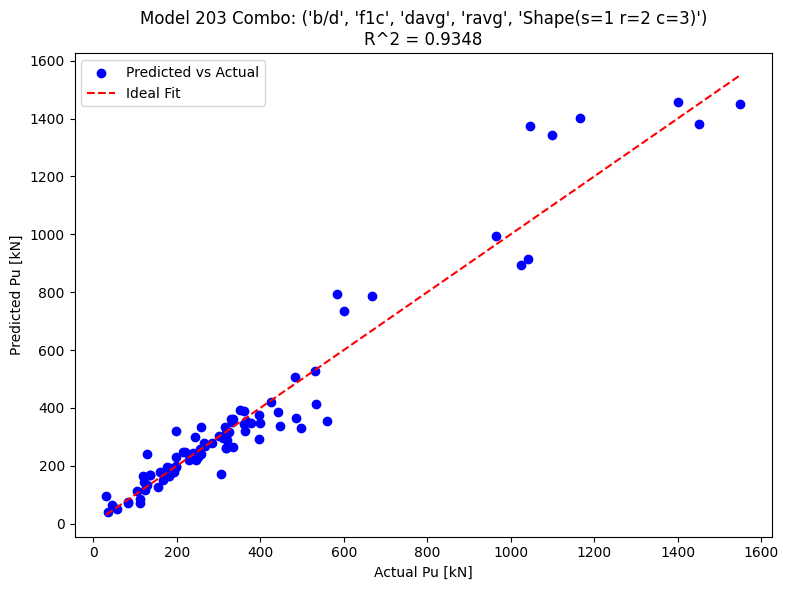

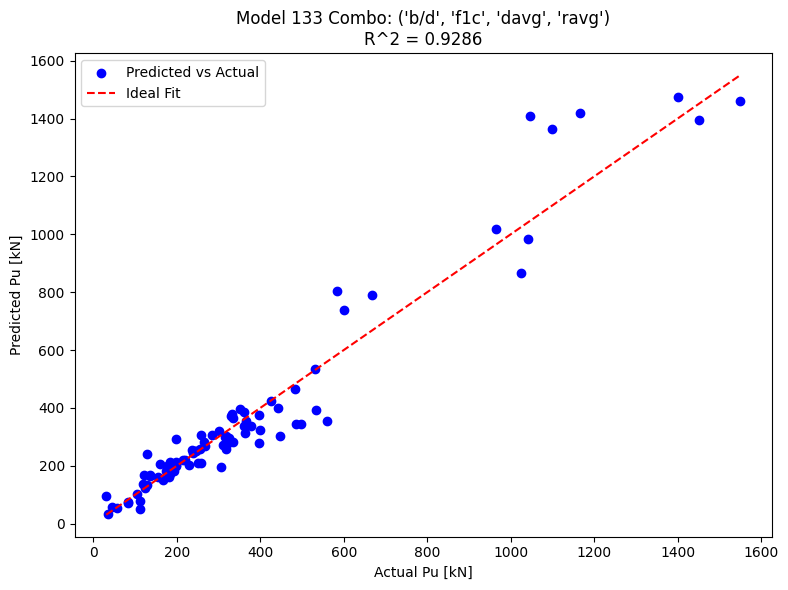

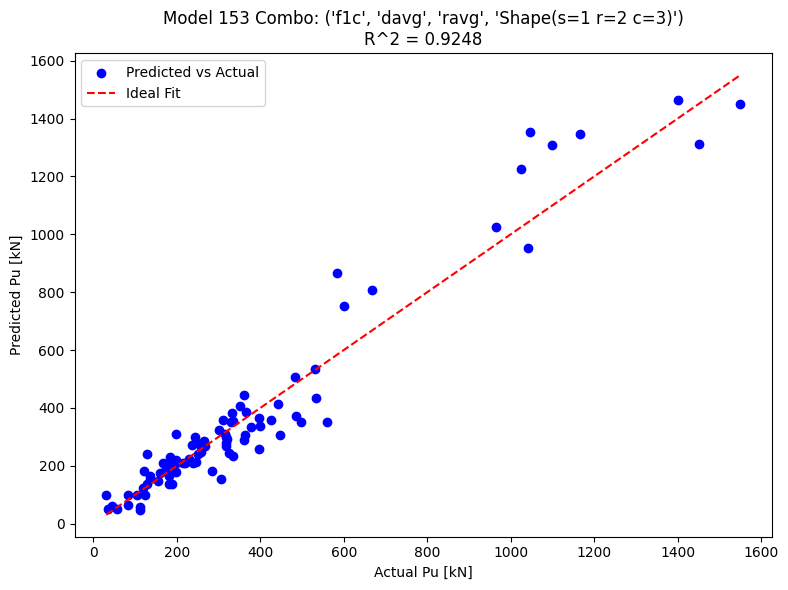

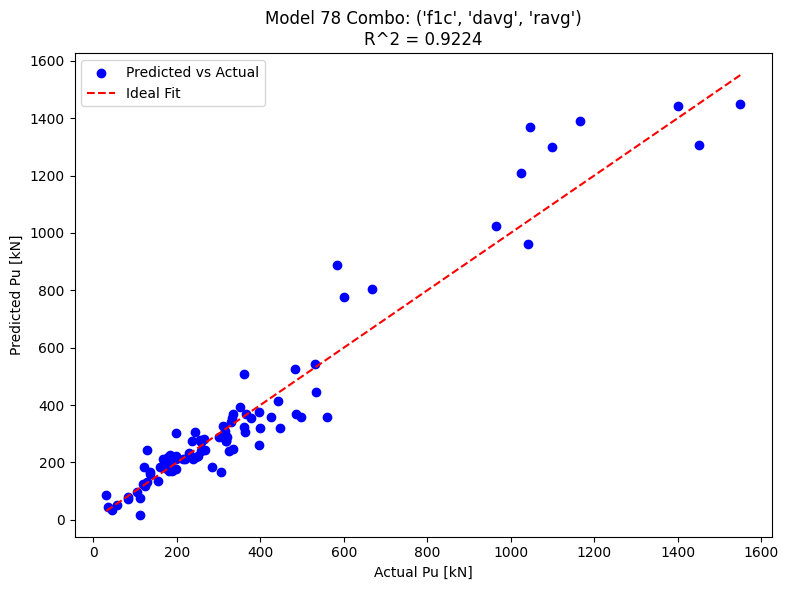

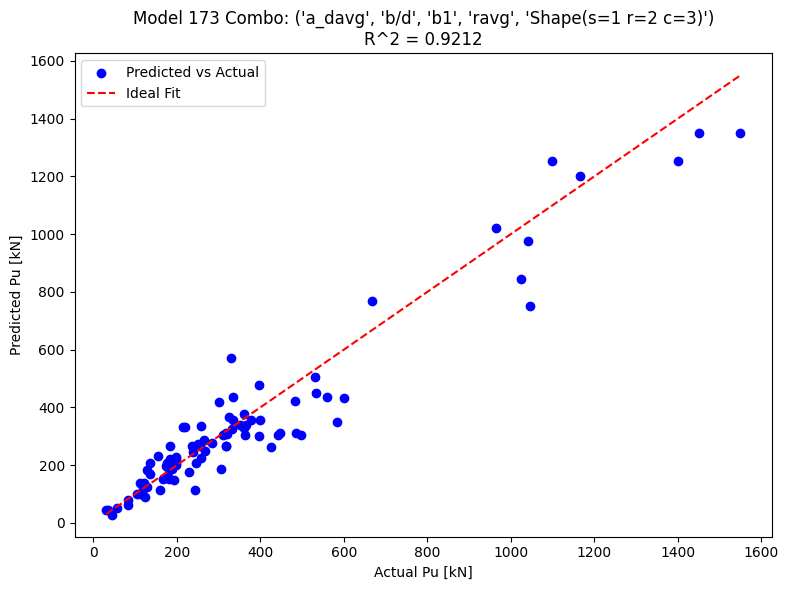

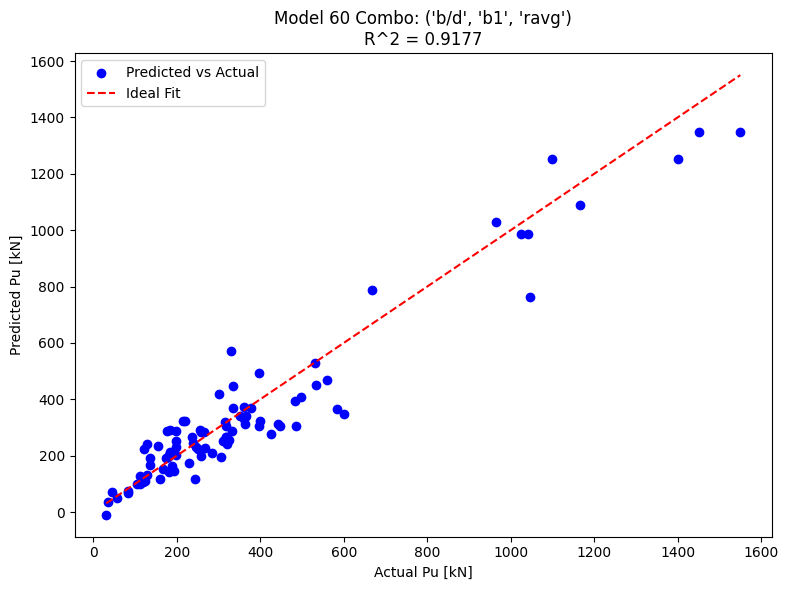

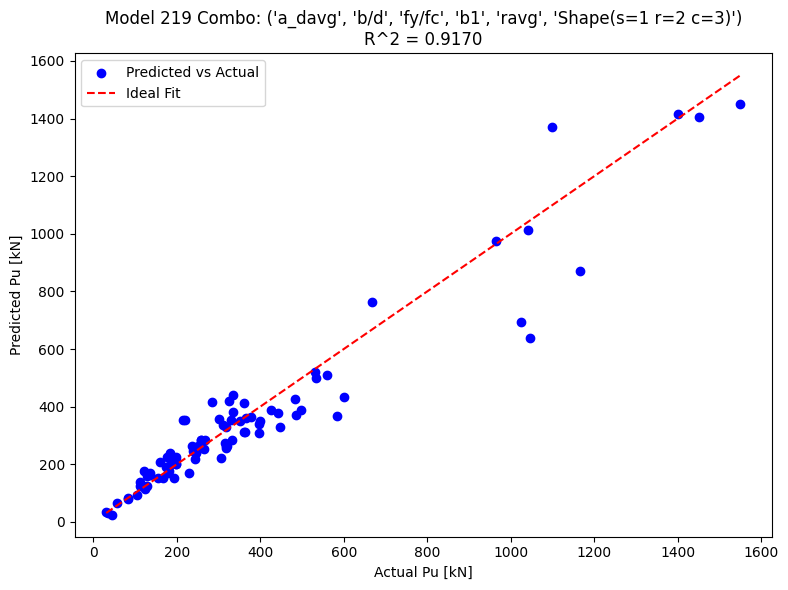

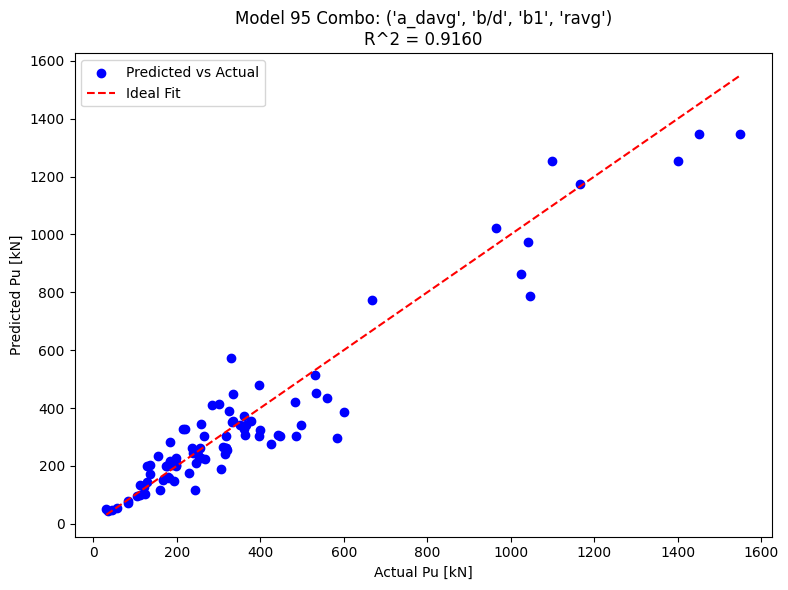

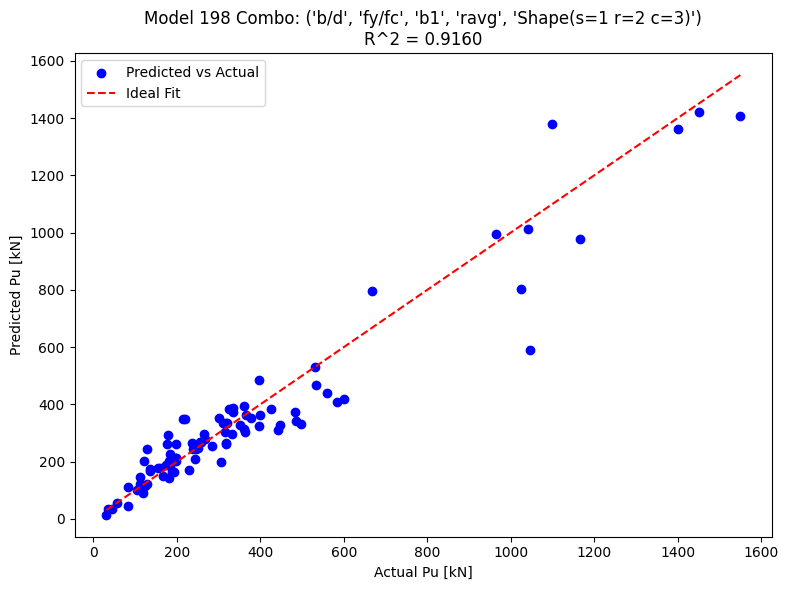

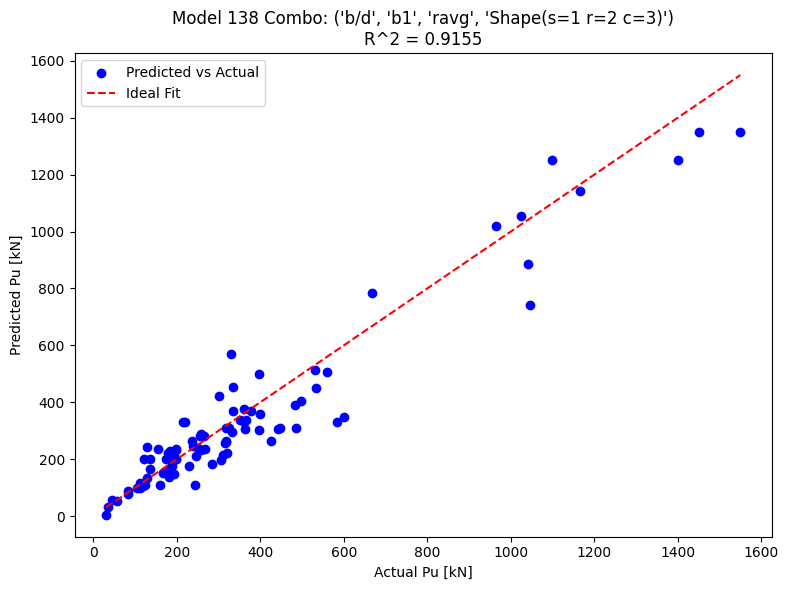

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import xgboost as xgb
import itertools
from tqdm import tqdm  # tqdm 임포트

# Excel 파일에서 데이터 불러오기
file_path = '../데이터 베이스/final_data.xlsx'
data = pd.read_excel(file_path, sheet_name='NEES_Database__ACI_445_Punching')

# 결측값이 있는 행을 삭제합니다.
data.dropna(inplace=True)

# 데이터를 준비합니다.
X = data[['a_davg', 'b/d', 'fy/fc', 'f1c', 'b1', 'davg', 'ravg', 'Shape(s=1 r=2 c=3)']]
y = data['Pu']

# 데이터를 훈련 세트와 테스트 세트로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모든 가능한 입력 변수 조합을 생성합니다.
features = X.columns
combinations = []
for r in range(2, len(features) + 1):  # 2개 조합부터 시작해서 전체 조합까지
    combinations.extend(itertools.combinations(features, r))

# 각 조합에 대해 XGBoost 모델 훈련 및 평가
r2_scores = {}
model_number = 1  # 모델 번호를 초기화
models_info = {}  # 모델 번호와 조합 정보를 저장할 딕셔너리

for combo in tqdm(combinations, desc="Training Models", unit="combination"):
    # 해당 조합으로 X_train, X_test를 선택합니다.
    X_train_combo = X_train[list(combo)]
    X_test_combo = X_test[list(combo)]
    
    # XGBoost 모델을 초기화하고 훈련시킵니다.
    model = xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train_combo, y_train)
    
    # 예측 수행
    y_pred = model.predict(X_test_combo)
    
    # R^2 계산
    r2 = r2_score(y_test, y_pred)
    
    # 모델 번호와 조합 저장
    r2_scores[model_number] = r2
    models_info[model_number] = combo
    model_number += 1

# R^2 값들을 내림차순으로 정렬하여 상위 10개 선택
sorted_r2_scores = sorted(r2_scores.items(), key=lambda x: x[1], reverse=True)[:10]

# 상위 10개 모델 번호와 R^2 값 추출
top_model_numbers = [item[0] for item in sorted_r2_scores]
top_r2_values = [item[1] for item in sorted_r2_scores]

# 출력: 상위 10개 모델 번호와 조합을 확인
print("Top 10 Feature Combinations (Model Number and R^2):")
for model_number, r2 in zip(top_model_numbers, top_r2_values):
    print(f'Model Number: {model_number}, Combination: {models_info[model_number]}, R^2: {r2:.4f}')

# 이제 상위 10개 모델을 다시 훈련해서 결과를 확인할 수 있습니다.
# 상위 10개 모델로 다시 훈련
for i, model_number in enumerate(top_model_numbers, 1):
    # 해당 조합으로 X_train, X_test를 선택합니다.
    combo = models_info[model_number]
    X_train_combo = X_train[list(combo)]
    X_test_combo = X_test[list(combo)]
    
    # XGBoost 모델을 초기화하고 훈련시킵니다.
    model = xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train_combo, y_train)
    
    # 예측 수행
    y_pred = model.predict(X_test_combo)
    
    # R^2 계산
    r2 = r2_score(y_test, y_pred)
    
    # 1:1 플롯 생성
    plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 25, 'font.family': 'Times New Roman'})  # Times New Roman으로 폰트 설정
    plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
    plt.xlabel('Actual Pu [kN]')
    plt.ylabel('Predicted Pu [kN]')
    plt.title(f'Model {model_number} Combo: {combo}\nR^2 = {r2:.4f}')
    plt.legend()
    plt.tight_layout()
    plt.show()


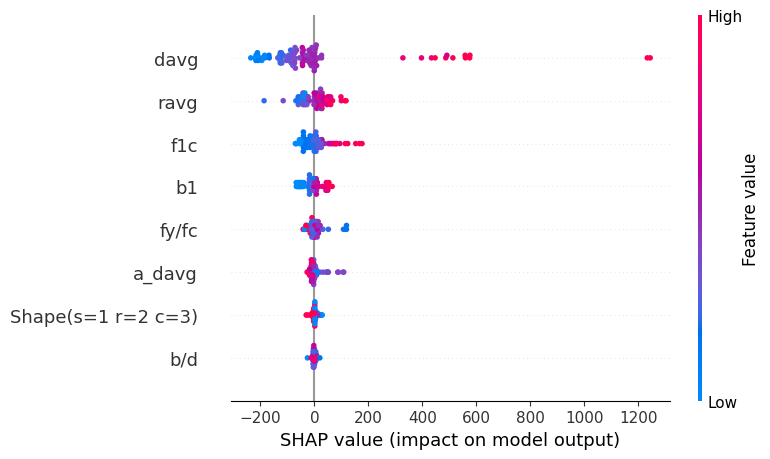

In [28]:
import pandas as pd
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Excel 파일에서 데이터 불러오기
file_path = '../데이터 베이스/final_data.xlsx'
data = pd.read_excel(file_path, sheet_name='NEES_Database__ACI_445_Punching')

# 결측값이 있는 행을 삭제합니다.
data.dropna(inplace=True)

# 데이터를 준비합니다.
X = data[['a_davg', 'b/d', 'fy/fc', 'f1c', 'b1', 'davg', 'ravg', 'Shape(s=1 r=2 c=3)']]
y = data['Pu']

# 데이터를 훈련 세트와 테스트 세트로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델을 훈련시킵니다.
model = xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# SHAP 값 계산
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# SHAP 값 시각화 - 특성 중요도를 나타내는 summary plot
shap.summary_plot(shap_values, X_test)

# SHAP 값 시각화 - 개별 예측에 대한 SHAP 값을 나타내는 force plot
# Force plot을 통해 개별 예측에 대한 각 특성의 영향을 확인할 수 있습니다.
# 첫 번째 테스트 샘플에 대한 force plot을 표시합니다.
shap.initjs()  # force plot을 표시하려면 JavaScript 필요
shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0])


R^2: 0.9348


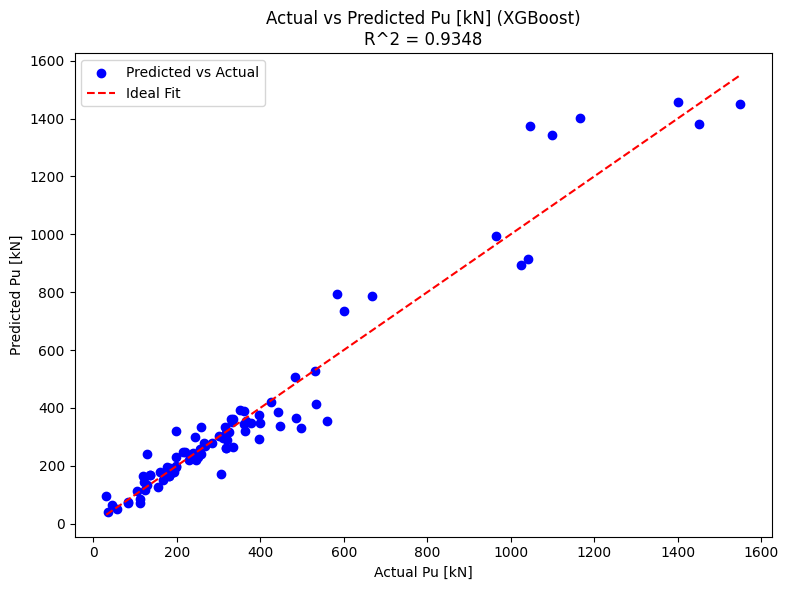

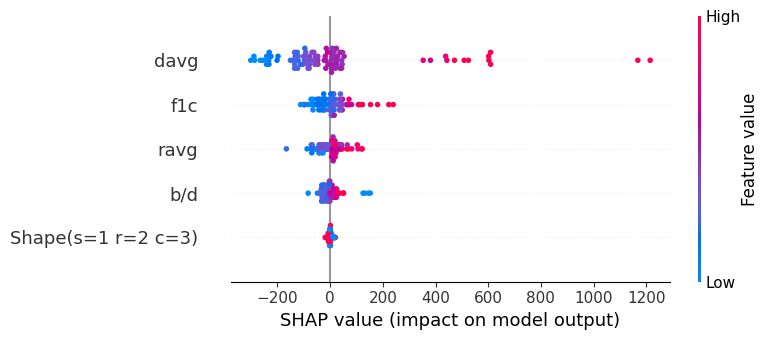

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import xgboost as xgb
import shap

# Excel 파일에서 데이터 불러오기
file_path = '../데이터 베이스/final_data.xlsx'
data = pd.read_excel(file_path, sheet_name='NEES_Database__ACI_445_Punching')

# 결측값이 있는 행을 삭제합니다.
data.dropna(inplace=True)

# 사용하려는 입력 변수로 데이터 준비
X = data[['b/d', 'f1c', 'davg', 'ravg', 'Shape(s=1 r=2 c=3)']]
y = data['Pu']

# 데이터를 훈련 세트와 테스트 세트로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델을 훈련시킵니다.
model = xgb.XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# 예측 수행
y_pred = model.predict(X_test)

# R^2 계산
r2 = r2_score(y_test, y_pred)

# 출력: R^2 값
print(f'R^2: {r2:.4f}')

# 1:1 플롯 생성
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Pu [kN]')
plt.ylabel('Predicted Pu [kN]')
plt.title(f'Actual vs Predicted Pu [kN] (XGBoost)\nR^2 = {r2:.4f}')
plt.legend()
plt.tight_layout()
plt.show()

# SHAP 값 계산
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# SHAP 값 시각화 - 특성 중요도를 나타내는 summary plot
shap.summary_plot(shap_values, X_test)

# SHAP 값 시각화 - 개별 예측에 대한 SHAP 값을 나타내는 force plot
shap.initjs()  # force plot을 표시하려면 JavaScript 필요
shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0])


[I 2025-07-10 13:12:13,430] A new study created in memory with name: no-name-6130442a-e1c3-4616-b6ca-dcde78b8083b
[I 2025-07-10 13:12:13,877] Trial 0 finished with value: 0.8804309964179993 and parameters: {'n_estimators': 196, 'max_depth': 7, 'learning_rate': 0.028156969624148247, 'subsample': 0.7949960776477981, 'colsample_bytree': 0.99391161818817, 'gamma': 0.2547246913308871, 'min_child_weight': 9}. Best is trial 0 with value: 0.8804309964179993.
[I 2025-07-10 13:12:14,026] Trial 1 finished with value: 0.9263651371002197 and parameters: {'n_estimators': 114, 'max_depth': 5, 'learning_rate': 0.0761989832524227, 'subsample': 0.7489384783772596, 'colsample_bytree': 0.8958090951602278, 'gamma': 0.001297492678261602, 'min_child_weight': 5}. Best is trial 1 with value: 0.9263651371002197.
[I 2025-07-10 13:12:14,199] Trial 2 finished with value: 0.6026253700256348 and parameters: {'n_estimators': 72, 'max_depth': 6, 'learning_rate': 0.008231713417622305, 'subsample': 0.8605109655775974, '

Best Parameters: {'n_estimators': 142, 'max_depth': 6, 'learning_rate': 0.09367394856161951, 'subsample': 0.9373692532938543, 'colsample_bytree': 0.8250775272531345, 'gamma': 0.00031053814574795257, 'min_child_weight': 7}
Best R^2: 0.9515
Best R^2: 0.9515


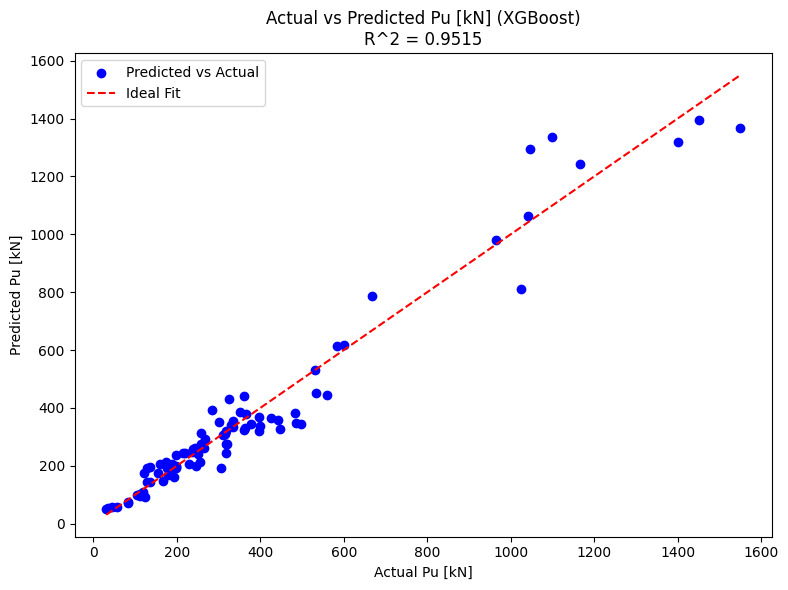

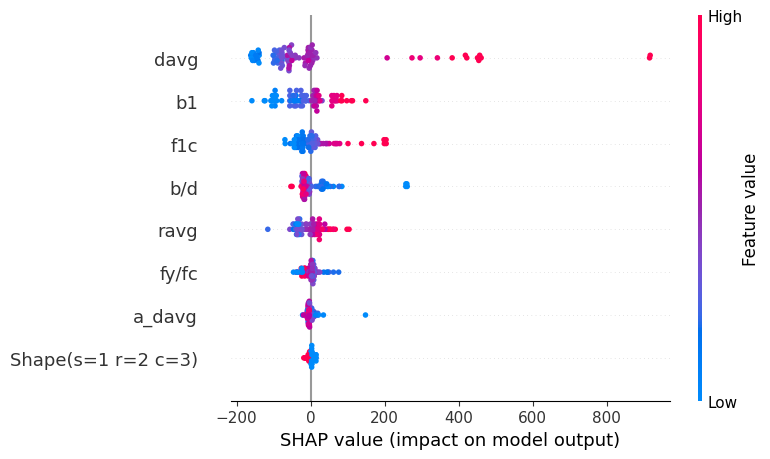

In [35]:
import pandas as pd
import xgboost as xgb
import shap
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Excel 파일에서 데이터 불러오기
file_path = '../데이터 베이스/final_data.xlsx'
data = pd.read_excel(file_path, sheet_name='NEES_Database__ACI_445_Punching')

# 결측값이 있는 행을 삭제합니다.
data.dropna(inplace=True)

# 데이터를 준비합니다.
X = data[['a_davg', 'b/d', 'fy/fc', 'f1c', 'b1', 'davg', 'ravg', 'Shape(s=1 r=2 c=3)']]
y = data['Pu']

# 데이터를 훈련 세트와 테스트 세트로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Objective function for Optuna (XGBoost 튜닝)
def objective(trial):
    # 하이퍼파라미터 범위 정의
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1),  # suggest_float 사용
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),  # suggest_float 사용
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),  # suggest_float 사용
        'gamma': trial.suggest_float('gamma', 1e-5, 1.0, log=True),  # suggest_float(log=True) 사용
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    # XGBoost 모델 훈련
    model = xgb.XGBRegressor(**param, random_state=42)
    model.fit(X_train, y_train)

    # 예측 수행
    y_pred = model.predict(X_test)

    # R^2 계산
    r2 = r2_score(y_test, y_pred)
    
    return r2  # 최대화해야 하기 때문에 R^2를 반환

# Optuna로 최적화 수행
study = optuna.create_study(direction='maximize')  # R^2 최대화
study.optimize(objective, n_trials=100)  # 100번 시도

# 최적의 하이퍼파라미터 출력
print(f"Best Parameters: {study.best_params}")
print(f"Best R^2: {study.best_value:.4f}")

# 최적의 하이퍼파라미터로 모델 학습
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# 예측 수행
y_pred = best_model.predict(X_test)

# R^2 계산
r2 = r2_score(y_test, y_pred)
print(f'Best R^2: {r2:.4f}')

# 1:1 플롯 생성
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Pu [kN]')
plt.ylabel('Predicted Pu [kN]')
plt.title(f'Actual vs Predicted Pu [kN] (XGBoost)\nR^2 = {r2:.4f}')
plt.legend()
plt.tight_layout()
plt.show()

# SHAP 값 계산
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

# SHAP 값 시각화 - 특성 중요도를 나타내는 summary plot
shap.summary_plot(shap_values, X_test)

# SHAP 값 시각화 - 개별 예측에 대한 SHAP 값을 나타내는 force plot
shap.initjs()  # force plot을 표시하려면 JavaScript 필요
shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0])


[I 2025-07-10 13:14:18,541] A new study created in memory with name: no-name-5c341751-b5c4-45af-894c-e32fc0652e8a
[I 2025-07-10 13:14:18,843] Trial 0 finished with value: 0.942533552646637 and parameters: {'n_estimators': 80, 'max_depth': 9, 'learning_rate': 0.04927590719137866, 'subsample': 0.7911898634120311, 'colsample_bytree': 0.9951463383922126, 'gamma': 0.10975073374342921, 'min_child_weight': 3}. Best is trial 0 with value: 0.942533552646637.
[I 2025-07-10 13:14:19,074] Trial 1 finished with value: 0.9046782851219177 and parameters: {'n_estimators': 176, 'max_depth': 4, 'learning_rate': 0.024966851663647507, 'subsample': 0.8599797439553724, 'colsample_bytree': 0.7769340354989214, 'gamma': 0.006596329358592662, 'min_child_weight': 8}. Best is trial 0 with value: 0.942533552646637.
[I 2025-07-10 13:14:19,222] Trial 2 finished with value: 0.9308016896247864 and parameters: {'n_estimators': 96, 'max_depth': 6, 'learning_rate': 0.046646770246668134, 'subsample': 0.7650771840953381, '

Best Parameters: {'n_estimators': 156, 'max_depth': 8, 'learning_rate': 0.030846073889714897, 'subsample': 0.9821426170115899, 'colsample_bytree': 0.926905089437058, 'gamma': 6.389588245578169e-05, 'min_child_weight': 2}
Best R^2: 0.9545
Best R^2: 0.9545


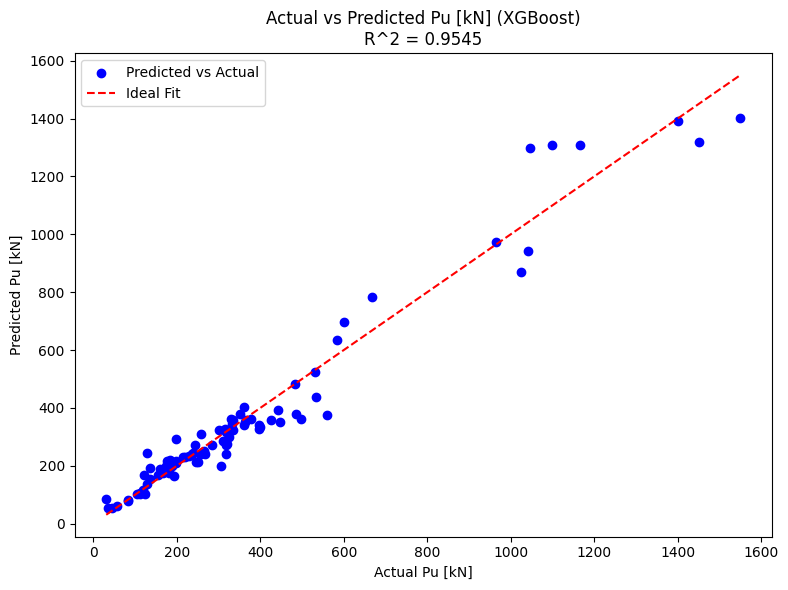

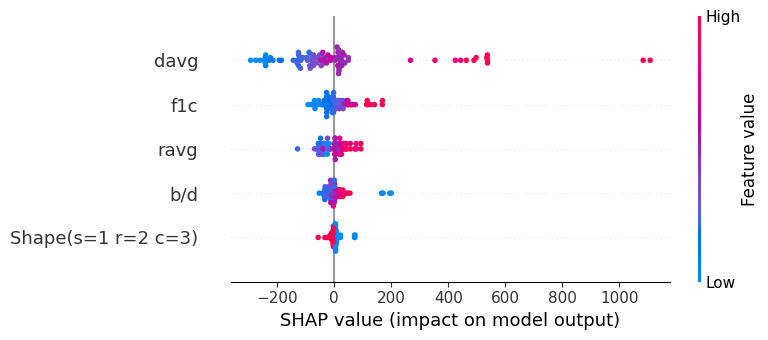

In [37]:
import pandas as pd
import xgboost as xgb
import shap
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Excel 파일에서 데이터 불러오기
file_path = '../데이터 베이스/final_data.xlsx'
data = pd.read_excel(file_path, sheet_name='NEES_Database__ACI_445_Punching')

# 결측값이 있는 행을 삭제합니다.
data.dropna(inplace=True)

# 데이터를 준비합니다.
X = data[['b/d', 'f1c', 'davg', 'ravg', 'Shape(s=1 r=2 c=3)']]
y = data['Pu']

# 데이터를 훈련 세트와 테스트 세트로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Objective function for Optuna (XGBoost 튜닝)
def objective(trial):
    # 하이퍼파라미터 범위 정의
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1),  # suggest_float 사용
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),  # suggest_float 사용
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),  # suggest_float 사용
        'gamma': trial.suggest_float('gamma', 1e-5, 1.0, log=True),  # suggest_float(log=True) 사용
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    # XGBoost 모델 훈련
    model = xgb.XGBRegressor(**param, random_state=42)
    model.fit(X_train, y_train)

    # 예측 수행
    y_pred = model.predict(X_test)

    # R^2 계산
    r2 = r2_score(y_test, y_pred)
    
    return r2  # 최대화해야 하기 때문에 R^2를 반환

# Optuna로 최적화 수행
study = optuna.create_study(direction='maximize')  # R^2 최대화
study.optimize(objective, n_trials=500)  # 100번 시도

# 최적의 하이퍼파라미터 출력
print(f"Best Parameters: {study.best_params}")
print(f"Best R^2: {study.best_value:.4f}")

# 최적의 하이퍼파라미터로 모델 학습
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# 예측 수행
y_pred = best_model.predict(X_test)

# R^2 계산
r2 = r2_score(y_test, y_pred)
print(f'Best R^2: {r2:.4f}')

# 1:1 플롯 생성
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Pu [kN]')
plt.ylabel('Predicted Pu [kN]')
plt.title(f'Actual vs Predicted Pu [kN] (XGBoost)\nR^2 = {r2:.4f}')
plt.legend()
plt.tight_layout()
plt.show()

# SHAP 값 계산
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

# SHAP 값 시각화 - 특성 중요도를 나타내는 summary plot
shap.summary_plot(shap_values, X_test)

# SHAP 값 시각화 - 개별 예측에 대한 SHAP 값을 나타내는 force plot
shap.initjs()  # force plot을 표시하려면 JavaScript 필요
shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0])


R^2: 0.9415


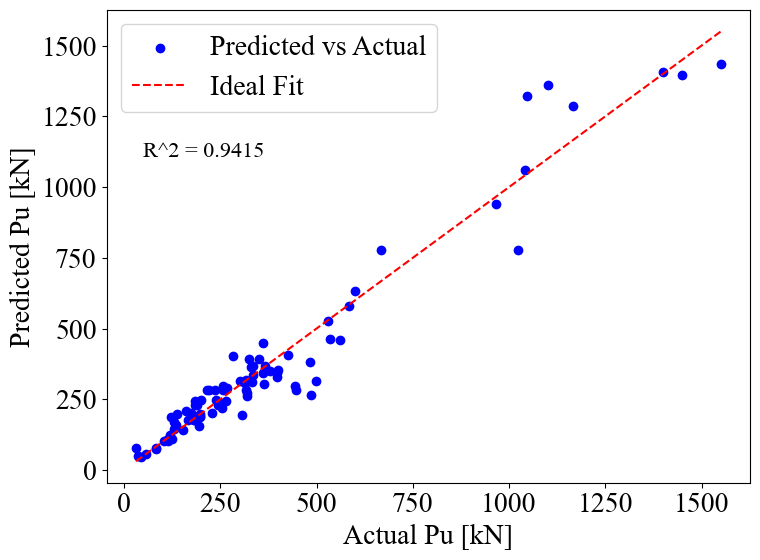

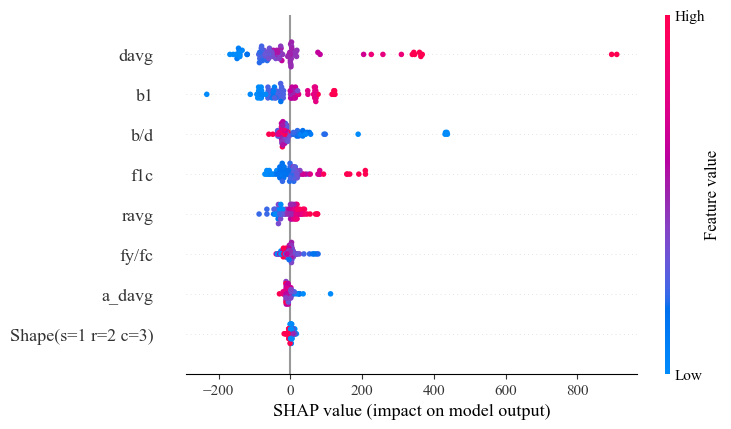

In [9]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import shap

# Excel 파일에서 데이터 불러오기
file_path = '../데이터 베이스/final_data.xlsx'
data = pd.read_excel(file_path, sheet_name='NEES_Database__ACI_445_Punching')

# 결측값이 있는 행을 삭제합니다.
data.dropna(inplace=True)

# 데이터를 준비합니다.
X = data[['a_davg', 'b/d', 'fy/fc', 'f1c', 'b1', 'davg', 'ravg', 'Shape(s=1 r=2 c=3)']]
y = data['Pu']

# 데이터를 훈련 세트와 테스트 세트로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 주어진 하이퍼파라미터로 모델을 초기화합니다.
params = {
    'n_estimators': 145,
    'max_depth': 9,
    'learning_rate': 0.07324219896306888,
    'subsample': 0.7227931676464613,
    'colsample_bytree': 0.7040466646492123,
    'gamma': 0.04756805563420427,
    'min_child_weight': 3
}

# XGBoost 모델을 초기화하고 훈련시킵니다.
model = xgb.XGBRegressor(**params, random_state=42)
model.fit(X_train, y_train)

# 예측 수행
y_pred = model.predict(X_test)

# R^2 계산
r2 = r2_score(y_test, y_pred)
print(f'R^2: {r2:.4f}')

# 1:1 플롯 생성
plt.rcParams.update({'font.size': 20, 'font.family': 'Times New Roman'})  # Times New Roman으로 폰트 설정
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Pu [kN]')
plt.ylabel('Predicted Pu [kN]')

# R^2 값을 그래프에 표시
plt.text(0.15, 0.7, f'R^2 = {r2:.4f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=16, color='black')

plt.legend()
plt.tight_layout()
plt.show()

# SHAP 값 계산
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# SHAP 값 시각화 - 특성 중요도를 나타내는 summary plot
shap.summary_plot(shap_values, X_test)

# SHAP 값 시각화 - 개별 예측에 대한 SHAP 값을 나타내는 force plot
shap.initjs()  # force plot을 표시하려면 JavaScript 필요
shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0])


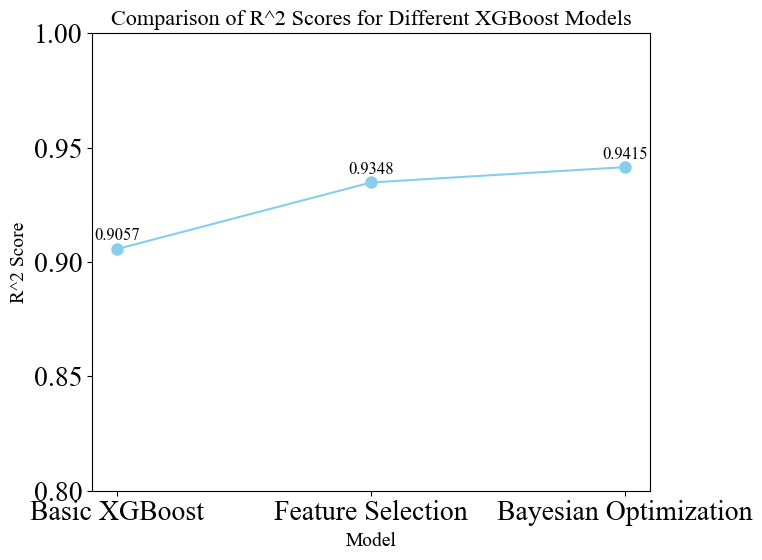

In [16]:
import matplotlib.pyplot as plt

# 모델 이름과 R^2 값
models = ['Basic XGBoost', 'Feature Selection', 'Bayesian Optimization']
r2_scores = [0.9057, 0.9348, 0.9415]

# 그래프 출력
plt.figure(figsize=(8, 6))

# 선 그래프 그리기
plt.plot(models, r2_scores, color='skyblue', marker='o', linestyle='-', markersize=8)

# R^2 값 그래프에 표시
for i, r2 in enumerate(r2_scores):
    plt.text(i, r2 + 0.002, f'{r2:.4f}', ha='center', va='bottom', fontsize=12, color='black')

# y축 범위 설정
plt.ylim(0.8, 1)

# y축 간격 설정
plt.yticks([i * 0.05 + 0.8 for i in range(5)])  # 0.8부터 시작해서 0.05 간격으로 5개의 값 설정

# 제목 및 레이블
plt.title('Comparison of R^2 Scores for Different XGBoost Models', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('R^2 Score', fontsize=14)

# 그래프 출력
plt.tight_layout()
plt.show()
